<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RNNregression_GRU_20seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
# Load data

data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [ ]:
# Preprocessing
data['Time_diff'] = data['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data['Latitude'].diff().fillna(0)
data['Lon_diff'] = data['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + 1e-5)
data.fillna(method='ffill', inplace=True)

In [ ]:
# Normalize features
scaler = MinMaxScaler()
numeric_columns = ['Latitude', 'Longitude']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [ ]:
def create_sequences(data, n_input=200, n_output=20):
    X, y = [], []
    for i in range(n_input, len(data) - n_output + 1):
        X.append(data.iloc[i-n_input:i][numeric_columns].values)
        y.append(data.iloc[i:i+n_output][['Latitude', 'Longitude']].values.flatten())
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_sequences(data)


In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# PyTorch datasets and loaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        # Apply a linear layer and tanh activation to get the energy scores
        energy = torch.tanh(self.attn(encoder_outputs))
        attention = self.v(energy)  # Reduce the dimensionality to 1 to get the attention scores
        attention = attention.squeeze(2)  # Remove the singleton dimension
        return F.softmax(attention, dim=1)

class GRUAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(GRUAttentionModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_size, num_layers = 2, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_dim)  # The output layer for final predictions

    def forward(self, x):
        gru_out, _ = self.gru(x)  # gru_out shape: (batch, seq_len, hidden_size)
        attn_weights = self.attention(gru_out)  # Compute attention weights for each timestep
        context_vector = torch.bmm(attn_weights.unsqueeze(1), gru_out).squeeze(1)  # Apply attention to the GRU outputs
        output = self.fc(context_vector)  # Pass the context vector through the final output layer
        return output


model = GRUAttentionModel(input_dim=2, hidden_size=64, output_dim=40).to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


Epoch 1: Train Loss: 0.0022, Validation Loss: 0.0004
Saving model (epoch 1, loss improved from inf to 0.0004)
Epoch 2: Train Loss: 0.0004, Validation Loss: 0.0005
Epoch 3: Train Loss: 0.0004, Validation Loss: 0.0004
Saving model (epoch 3, loss improved from 0.0004 to 0.0004)
Epoch 4: Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 5: Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 6: Train Loss: 0.0004, Validation Loss: 0.0004
Saving model (epoch 6, loss improved from 0.0004 to 0.0004)
Epoch 7: Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 8: Train Loss: 0.0004, Validation Loss: 0.0004
Saving model (epoch 8, loss improved from 0.0004 to 0.0004)
Epoch 9: Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 10: Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 11: Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 12: Train Loss: 0.0004, Validation Loss: 0.0004
Saving model (epoch 12, loss improved from 0.0004 to 0.0004)
Epoch 13: Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 14:

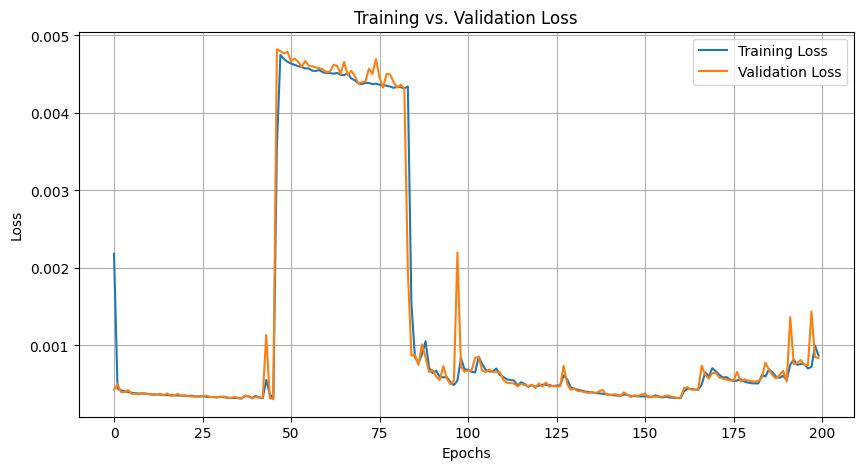

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    # Lists to store loss per epoch for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Save the model if the validation loss has improved
        if avg_val_loss < best_val_loss:
            print(f'Saving model (epoch {epoch+1}, loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f})')
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



train_and_validate(model, train_loader, test_loader, num_epochs=200, device=device)



In [ ]:
# Helper function to convert GPS coordinates to meters
def gps_to_meters(lat_diff, lon_diff, ref_lat):
    lat_meters = lat_diff * 111000  # 1 degree latitude ≈ 111 km
    lon_meters = lon_diff * (111000 * np.cos(np.radians(ref_lat)))  # 1 degree longitude ≈ 111 km * cos(latitude)
    return lat_meters, lon_meters

In [ ]:
torch.save(model.state_dict(), 'GRUseq20.pth')

In [ ]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('GRUseq20.pth')) #Load the model
    model.to(device)
    model.eval()

    all_past_data = []
    all_predictions = []
    all_actuals = []
    all_past_data_meters = []
    all_predictions_meters = []
    all_actuals_meters = []
    rmses = []
    rmses_meters = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 20, 2).cpu().numpy()
            actuals = y_batch.view(-1, 20, 2).cpu().numpy()
            past_data = X_batch[:, -200:, :2].view(-1, 200, 2).cpu().numpy()  # Assuming the last 200 points are relevant

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 20, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 20, 2)
            past_data = scaler.inverse_transform(past_data.reshape(-1, 2)).reshape(-1, 200, 2)

            # Convert to meters

            ref_lat = actuals[0, 0, 0]
            predictions_meters = np.array([gps_to_meters(pred[:, 0], pred[:, 1], ref_lat) for pred in predictions])
            actuals_meters = np.array([gps_to_meters(act[:, 0], act[:, 1], ref_lat) for act in actuals])
            past_data_meters = np.array([gps_to_meters(past[:, 0], past[:, 1], ref_lat) for past in past_data])

            all_past_data.append(past_data)
            all_predictions.append(predictions)
            all_actuals.append(actuals)
            all_past_data_meters.append(past_data_meters)
            all_predictions_meters.append(np.array(predictions_meters))
            all_actuals_meters.append(np.array(actuals_meters))

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)




    average_rmse = np.mean(rmses)

    return all_past_data, all_actuals, all_predictions, all_past_data_meters, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse


all_past_data, all_actuals, all_predictions, all_past_data_meters, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse = evaluate_model(model, test_loader, device='cuda', scaler=scaler)
print("Average RMSE:", average_rmse)




Average RMSE: 0.03566124


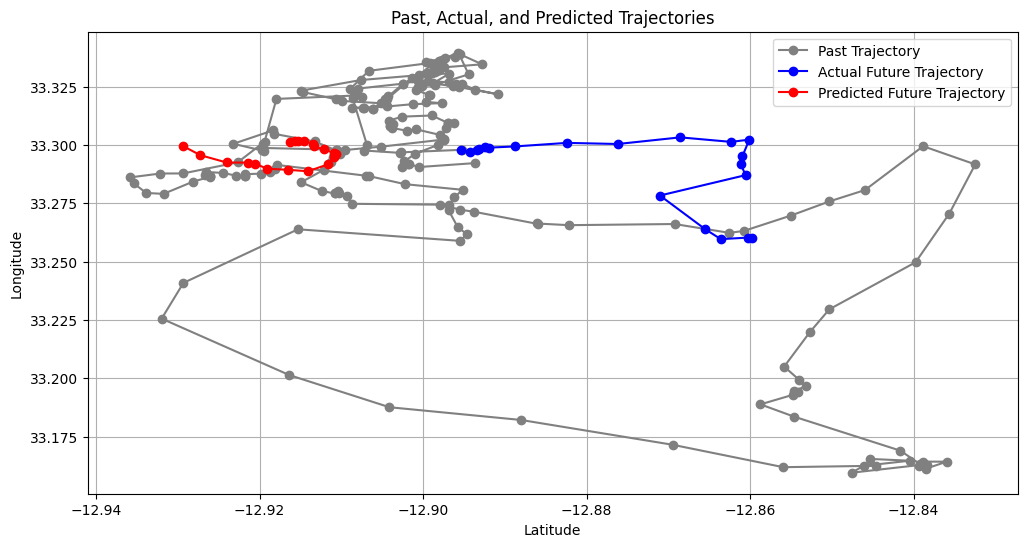

In [ ]:
def plot_trajectories(past_data, actuals, predictions, index=0):
    plt.figure(figsize=(12, 6))
    # Plot the past trajectory
    plt.plot(past_data[index][0][:, 0], past_data[index][0][:, 1], 'gray', label='Past Trajectory', marker='o')
    # Plot the actual future trajectory
    plt.plot(actuals[index][0][:, 0], actuals[index][0][:, 1], 'bo-', label='Actual Future Trajectory')
    # Plot the predicted future trajectory
    plt.plot(predictions[index][0][:, 0], predictions[index][0][:, 1], 'ro-', label='Predicted Future Trajectory')

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Past, Actual, and Predicted Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectories(all_past_data, all_actuals, all_predictions, index=0)



In [ ]:
!pip install geopandas
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 60.9 MB/s eta 0:00:00


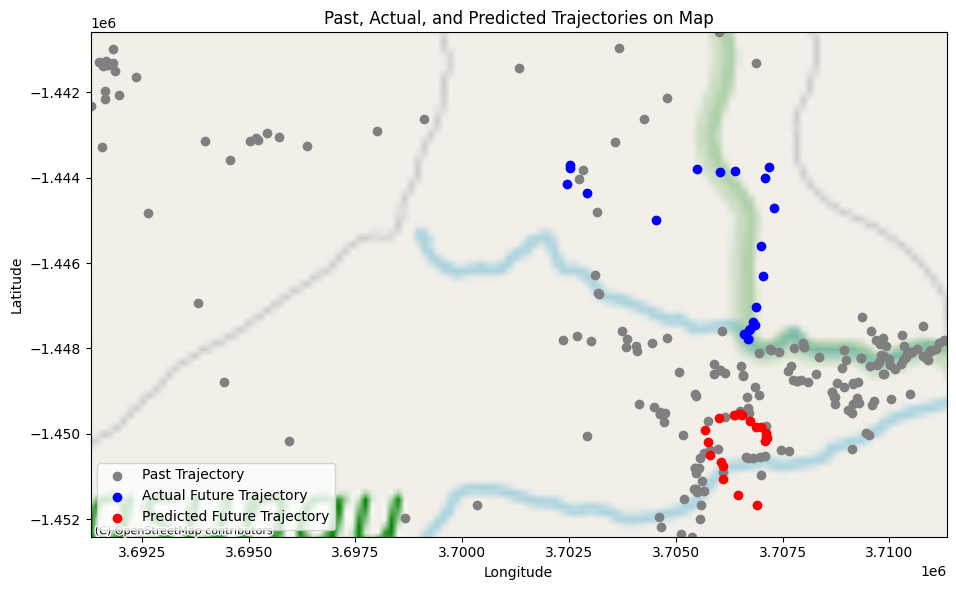

In [ ]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Convert trajectories to GeoDataFrames
def to_geodataframe_trajectory(trajectory, crs="EPSG:4326"):
    geometry = [Point(xy) for xy in zip(trajectory[:, 1], trajectory[:, 0])]
    return gpd.GeoDataFrame(geometry=geometry, crs=crs)

#function to  Plot trajectories on a map
def plot_trajectories_on_map(past_data, actuals, predictions, index=0):
    # Convert trajectories to GeoDataFrames
    gdf_past = to_geodataframe_trajectory(past_data[index][0])
    gdf_actuals = to_geodataframe_trajectory(actuals[index][0])
    gdf_predictions = to_geodataframe_trajectory(predictions[index][0])

    # Convert GeoDataFrames to Web Mercator for contextily
    gdf_past = gdf_past.to_crs(epsg=3857)
    gdf_actuals = gdf_actuals.to_crs(epsg=3857)
    gdf_predictions = gdf_predictions.to_crs(epsg=3857)

    # Determine common axis limits
    min_lat = min(gdf_past.geometry.y.min(), gdf_actuals.geometry.y.min(), gdf_predictions.geometry.y.min())
    max_lat = max(gdf_past.geometry.y.max(), gdf_actuals.geometry.y.max(), gdf_predictions.geometry.y.max())
    min_lon = min(gdf_past.geometry.x.min(), gdf_actuals.geometry.x.min(), gdf_predictions.geometry.x.min())
    max_lon = max(gdf_past.geometry.x.max(), gdf_actuals.geometry.x.max(), gdf_predictions.geometry.x.max())

    # Plot the trajectories on a map
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot past, actual, and predicted trajectories
    gdf_past.plot(ax=ax, color='gray', label='Past Trajectory', marker='o')
    gdf_actuals.plot(ax=ax, color='blue', label='Actual Future Trajectory', marker='o')
    gdf_predictions.plot(ax=ax, color='red', label='Predicted Future Trajectory', marker='o')
    ctx.add_basemap(ax, crs=gdf_past.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom =10)  # Increase zoom level
    ax.set_title('Past, Actual, and Predicted Trajectories on Map')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_trajectories_on_map(all_past_data, all_actuals, all_predictions, index=0)


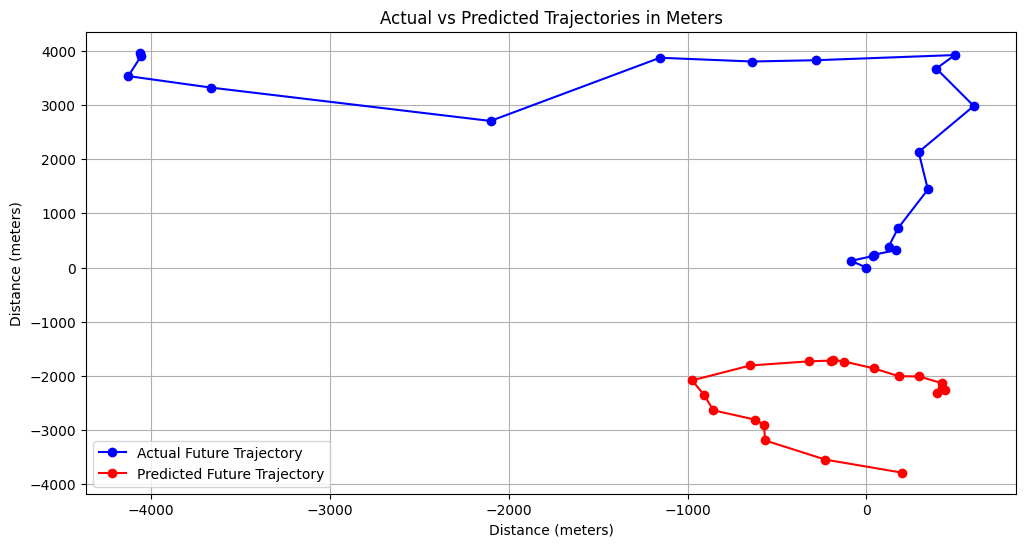

Actual_Lat | Actual_Lon |   Pred_Lat |   Pred_Lon |  Actual_X(m) |    Pred_X(m) |  Diff_X(m) |  Actual_Y(m) |    Pred_Y(m) |  Diff_Y(m)
----------------------------------------------------------------------------------------------------------------------------------
-12.895350 |  33.297722 | -12.929406 |  33.299591 |         0.00 |       202.48 |    -202.48 |         0.00 |     -3786.87 |    3786.87
-12.894244 |  33.296936 | -12.927234 |  33.295612 |       -85.14 |      -228.76 |     143.62 |       123.04 |     -3545.26 |    3668.30
-12.893450 |  33.298054 | -12.924048 |  33.292500 |        35.91 |      -565.98 |     601.89 |       211.33 |     -3191.06 |    3402.39
-12.893203 |  33.298138 | -12.921468 |  33.292439 |        45.16 |      -572.64 |     617.80 |       238.76 |     -2904.17 |    3142.93
-12.892467 |  33.299263 | -12.920609 |  33.292000 |       166.94 |      -620.39 |     787.34 |       320.69 |     -2808.57 |    3129.26
-12.891898 |  33.298870 | -12.919046 |  33.289825 |  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the Earth's radius
R = 6371000  # Earth radius in meters

# Function to convert latitude and longitude to x and y coordinates in meters
def lat_lon_to_xy(lat, lon, ref_lat, ref_lon):
    lat, lon, ref_lat, ref_lon = map(np.radians, [lat, lon, ref_lat, ref_lon])
    dlon = lon - ref_lon
    dlat = lat - ref_lat
    x = R * dlon * np.cos(ref_lat)
    y = R * dlat
    return x, y

# Function to convert a trajectory to meters
def convert_trajectory_to_meters(trajectory, ref_lat, ref_lon):
    x_meters, y_meters = [], []
    for lat, lon in trajectory:
        x, y = lat_lon_to_xy(lat, lon, ref_lat, ref_lon)
        x_meters.append(x)
        y_meters.append(y)
    return np.array(x_meters), np.array(y_meters)

# Evaluation function
def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('GRUseq20.pth'))
    model.to(device)
    model.eval()

    all_actuals = []
    all_predictions = []
    all_actuals_meters = []
    all_predictions_meters = []
    rmses = []
    rmses_meters = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 20, 2).cpu().numpy()
            actuals = y_batch.view(-1, 20, 2).cpu().numpy()

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 20, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 20, 2)

            # Convert to meters using the first point of the actual trajectory as the reference
            ref_lat, ref_lon = actuals[0][0]
            predictions_meters = [convert_trajectory_to_meters(pred, ref_lat, ref_lon) for pred in predictions]
            actuals_meters = [convert_trajectory_to_meters(act, ref_lat, ref_lon) for act in actuals]

            all_actuals.append(actuals)
            all_predictions.append(predictions)
            all_actuals_meters.append(actuals_meters)
            all_predictions_meters.append(predictions_meters)

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)

            batch_rmse_meters = np.sqrt(mean_squared_error(np.vstack(predictions_meters).reshape(-1, 2), np.vstack(actuals_meters).reshape(-1, 2)))
            rmses_meters.append(batch_rmse_meters)

    average_rmse = np.mean(rmses)
    average_rmse_meters = np.mean(rmses_meters)


    all_actuals = np.vstack(all_actuals)
    all_predictions = np.vstack(all_predictions)
    all_actuals_meters = np.vstack(all_actuals_meters)
    all_predictions_meters = np.vstack(all_predictions_meters)

    return all_actuals, all_predictions, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse, average_rmse_meters

# Plotting function
def plot_trajectories_in_meters(actuals_meters, predictions_meters, index=0):
    actual_x, actual_y = actuals_meters[index]
    pred_x, pred_y = predictions_meters[index]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_x, actual_y, 'bo-', label='Actual Future Trajectory')
    plt.plot(pred_x, pred_y, 'ro-', label='Predicted Future Trajectory')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Distance (meters)')
    plt.title('Actual vs Predicted Trajectories in Meters')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print trajectories in meters
def print_trajectories_in_meters(actuals, predictions, actuals_meters, predictions_meters, index=0):
    actual_lat_lon = actuals[index].reshape(-1, 2)
    predicted_lat_lon = predictions[index].reshape(-1, 2)

    actual_x, actual_y = actuals_meters[index][0], actuals_meters[index][1]
    pred_x, pred_y = predictions_meters[index][0], predictions_meters[index][1]

    diff_x = actual_x - pred_x
    diff_y = actual_y - pred_y

    actual_vs_predicted = np.column_stack((actual_lat_lon, predicted_lat_lon, actual_x, pred_x, diff_x, actual_y, pred_y, diff_y))

    print(f"{'Actual_Lat':>10} | {'Actual_Lon':>10} | {'Pred_Lat':>10} | {'Pred_Lon':>10} | {'Actual_X(m)':>12} | {'Pred_X(m)':>12} | {'Diff_X(m)':>10} | {'Actual_Y(m)':>12} | {'Pred_Y(m)':>12} | {'Diff_Y(m)':>10}")
    print("-" * 130)

    for row in actual_vs_predicted:
        print(f"{row[0]:>10.6f} | {row[1]:>10.6f} | {row[2]:>10.6f} | {row[3]:>10.6f} | {row[4]:>12.2f} | {row[5]:>12.2f} | {row[6]:>10.2f} | {row[7]:>12.2f} | {row[8]:>12.2f} | {row[9]:>10.2f}")


all_actuals, all_predictions, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse, average_rmse_meters = evaluate_model(model, test_loader, device='cuda', scaler=scaler)

# Plot trajectories in meters
plot_trajectories_in_meters(all_actuals_meters, all_predictions_meters, index=0)

# Print trajectories in meters
print_trajectories_in_meters(all_actuals, all_predictions, all_actuals_meters, all_predictions_meters, index=0)


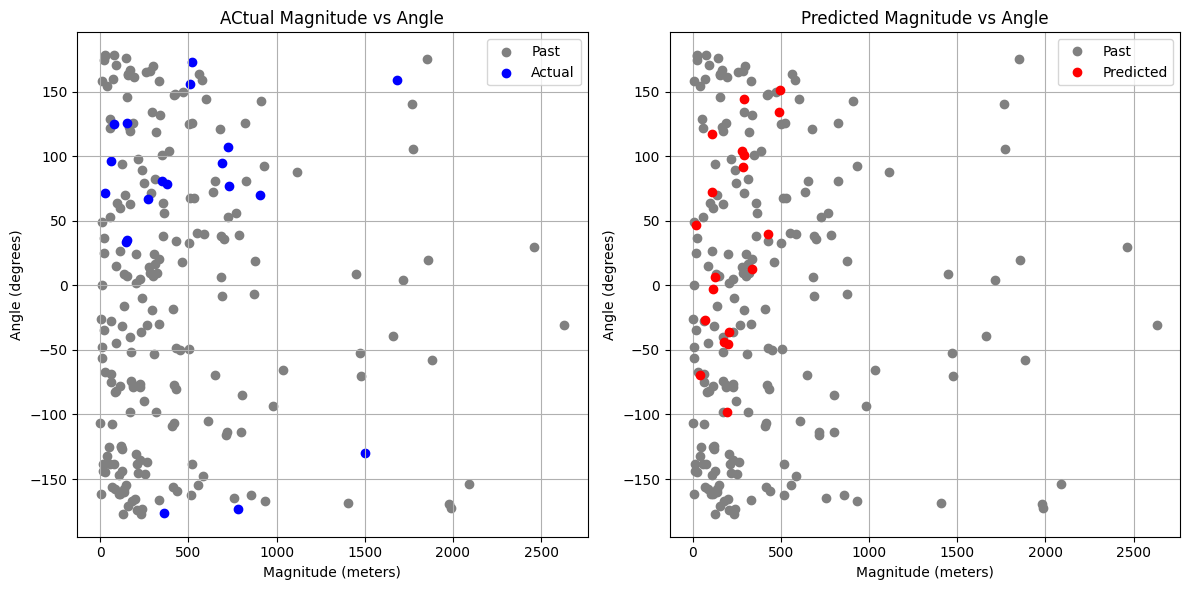

Actual Mag (m)  Pred Mag (m)    Actual Ang      Pred Ang       
------------------------------------------------------------
149.621757      494.255019      125.387889      151.364533     
149.933891      489.139131      35.403343       134.340669     
28.932541       287.030618      71.233867       91.354859      
146.902610      106.721367      33.194211       117.046302     
76.212183       292.756978      124.655146      144.305751     
347.446822      287.636338      80.873832       100.527605     
732.044461      277.347896      76.514586       104.322725     
692.731071      426.009131      94.424264       39.478200      
904.190393      335.761675      69.579608       12.768257      
722.493989      123.228439      107.277943      6.552555       
269.918848      19.415586       66.766083       46.311893      
782.447119      70.409566       -173.175581     -26.943237     
358.921102      207.395781      -176.267170     -36.224407     
519.895456      199.747798      172.535674 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Haversine formula to calculate the distance between two lat/lon points in meters
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    meters = R * c  # Output distance in meters
    return meters

# Function to calculate magnitude (distance in meters) and angle from lat, lon coordinates
def calculate_magnitude_angle(lat_diff, lon_diff, lat1, lon1, lat2, lon2):
    magnitude = haversine(lat1, lon1, lat2, lon2)
    angle = np.arctan2(lat_diff, lon_diff) * 180 / np.pi  # Convert radians to degrees
    return magnitude, angle

# Function to calculate magnitudes and angles for a trajectory
def trajectory_magnitude_angle(trajectory):
    lat_diff = np.diff(trajectory[:, 0])
    lon_diff = np.diff(trajectory[:, 1])
    magnitudes = []
    angles = []
    for i in range(len(lat_diff)):
        mag, ang = calculate_magnitude_angle(lat_diff[i], lon_diff[i], trajectory[i, 0], trajectory[i, 1], trajectory[i+1, 0], trajectory[i+1, 1])
        magnitudes.append(mag)
        angles.append(ang)
    return np.array(magnitudes), np.array(angles)

# Function to plot magnitude vs angle
def plot_magnitude_angle(past_data, actuals, predictions, index=0):
    past_trajectory = past_data[index]
    actual_trajectory = actuals[index].reshape(-1, 2)
    predicted_trajectory = predictions[index].reshape(-1, 2)

    past_magnitudes, past_angles = trajectory_magnitude_angle(past_trajectory)
    actual_magnitudes, actual_angles = trajectory_magnitude_angle(actual_trajectory)
    pred_magnitudes, pred_angles = trajectory_magnitude_angle(predicted_trajectory)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(past_magnitudes, past_angles, label='Past', color='gray', marker='o')
    plt.scatter(actual_magnitudes, actual_angles, label='Actual', color='blue', marker='o')

    plt.title('ACtual Magnitude vs Angle')
    plt.xlabel('Magnitude (meters)')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(past_magnitudes, past_angles, label='Past', color='gray', marker='o', linestyle='None')

    plt.plot(pred_magnitudes, pred_angles, label='Predicted', color='red', marker='o', linestyle='None')
    plt.title('Predicted Magnitude vs Angle')
    plt.xlabel('Magnitude (meters)')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


    print("{:<15} {:<15} {:<15} {:<15}".format("Actual Mag (m)", "Pred Mag (m)", "Actual Ang", "Pred Ang"))
    print("-" * 60)
    for actual_mag, pred_mag, actual_ang, pred_ang in zip(actual_magnitudes, pred_magnitudes, actual_angles, pred_angles):
        print("{:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}".format(actual_mag, pred_mag, actual_ang, pred_ang))

# Updated evaluation function
def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('GRUseq20.pth'))
    model.to(device)
    model.eval()

    all_actuals = []
    all_predictions = []
    rmses = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 20, 2).cpu().numpy()
            actuals = y_batch.view(-1, 20, 2).cpu().numpy()

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 20, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 20, 2)

            all_actuals.append(actuals)
            all_predictions.append(predictions)

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)

    average_rmse = np.mean(rmses)

    all_actuals = np.vstack(all_actuals)
    all_predictions = np.vstack(all_predictions)

    return all_actuals, all_predictions, rmses, average_rmse


all_actuals, all_predictions, rmses, average_rmse = evaluate_model(model, test_loader, device='cuda', scaler=scaler)

# Plot magnitude vs angle
plot_magnitude_angle(X_test, all_actuals, all_predictions, index=0)
